In [79]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from collections import Counter
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.tree
import sklearn.svm
%matplotlib inline

In [2]:
yelp_test = pd.read_csv('Datasets/yelp-test-ORIGINAL.txt', header=None, sep="\t")
yelp_train = pd.read_csv('Datasets/yelp-train-ORIGINAL.txt', header=None, sep="\t")
yelp_valid = pd.read_csv('Datasets/yelp-valid-ORIGINAL.txt', header=None, sep="\t")

In [3]:
imdb_test = pd.read_csv('Datasets/IMDB-test-ORIGINAL.txt', header=None, sep="\t")
imdb_train = pd.read_csv('Datasets/IMDB-train-ORIGINAL.txt', header=None, sep="\t")
imdb_valid = pd.read_csv('Datasets/IMDB-valid-ORIGINAL.txt', header=None, sep="\t")

In [6]:
#Cleaning data and getting top 10000
def getTopWords(reviews):
    allWords = []
    topWords = []
    
    for review in reviews[0]:
        allWords.extend(review.lower().translate(str.maketrans("","", string.punctuation)).split(' '))
    
    c = Counter()
    for word in allWords:
        if (word != ''):
            c[word] += 1
        
    topWords = c.most_common(10000)
    return {tupl[0]: index for index, tupl in enumerate(topWords)}, [tupl[0] + '\t' + str(index) + '\t' + str(tupl[1])  for index, tupl in enumerate(topWords)]
    

In [11]:
yelpDict, yelpOutput = getTopWords(yelp_train)

In [12]:
imdbDict, imdbOutput = getTopWords(imdb_train)

In [40]:
# Saving vocab data to .txt file

f = open("Datasets/IMDB-vocab.txt", 'w',encoding='utf-8')
c = 0
for line in imdbOutput:
    if c == 0:  
        f.write(line)
    else:
        f.write('\n')
        f.write(line)
    c += 1
f.close()

f = open("Datasets/yelp-vocab.txt", 'w',encoding='utf-8')
c = 0
for line in yelpOutput:
    if c == 0:  
        f.write(line)
    else:
        f.write('\n')
        f.write(line)
    c += 1
f.close()

In [48]:
def saveReviewsIDs(dic, reviews, out):
    f = open(out, 'w',encoding='utf-8')
    c = 0
    for review, categ in zip(reviews[0], reviews[1]):
        if c != 0:
            f.write('\n')
        r = review.lower().translate(str.maketrans("","", string.punctuation)).split(' ')
        for index, word in enumerate(r):
            if word in dic:
                if index != 0:
                    f.write(' ')
                f.write(str(dic[word]))
        f.write('\t')
        f.write(str(categ))
        c += 1

    f.close()

In [49]:
saveReviewsIDs(imdbDict, imdb_test, "Datasets/IMDB-test.txt")
saveReviewsIDs(imdbDict, imdb_train, "Datasets/IMDB-train.txt")
saveReviewsIDs(imdbDict, imdb_valid, "Datasets/IMDB-valid.txt")

saveReviewsIDs(yelpDict, yelp_test, "Datasets/yelp-test.txt")
saveReviewsIDs(yelpDict, yelp_train, "Datasets/yelp-train.txt")
saveReviewsIDs(yelpDict, yelp_valid, "Datasets/yelp-valid.txt")

In [54]:
def binBagWords(dictIndex, reviews):
    m = []
    for review in reviews[0]:
        vect = [0] * len(dictIndex)
        for word in review:
            if word in dictIndex:
                vect[dictIndex[word]] = 1
        m.append(vect)
    return np.array(m)

In [55]:
def freqBagWords(dictIndex, reviews):
    m = []
    for review in reviews[0]:
        vect = [0] * len(dictIndex)
        for word in review:
            if word in dictIndex:
                vect[dictIndex[word]] += 1
        s = sum(vect)
        if s > 0:
            vect = np.divide(vect, s)
        m.append(vect)
    return np.array(m)

In [61]:
yelpTrainBinBag = binBagWords(yelpDict, yelp_train)
yelpTrainFreqBag = freqBagWords(yelpDict, yelp_train)

yelpTestBinBag = binBagWords(yelpDict, yelp_test)
yelpTestFreqBag = freqBagWords(yelpDict, yelp_test)

yelpValidBinBag = binBagWords(yelpDict, yelp_valid)
yelpValidFreqBag = freqBagWords(yelpDict, yelp_valid)

In [62]:
imdbTrainBinBag = binBagWords(imdbDict, imdb_train)
imdbTrainFreqBag = freqBagWords(imdbDict, imdb_train)

imdbTestBinBag = binBagWords(imdbDict, imdb_test)
imdbTestFreqBag = freqBagWords(imdbDict, imdb_test)

imdbValidBinBag = binBagWords(imdbDict, imdb_valid)
imdbValidFreqBag = freqBagWords(imdbDict, imdb_valid)

# YELP

In [202]:
# Random classifier
rand = np.random.choice([1,2,3,4,5], len(yelp_test[1]))
sklearn.metrics.f1_score(yelp_test[1], rand, average='micro')

0.20499999999999999

In [203]:
# Majority-class classifier
majority = np.argmax(np.bincount(yelp_train[1]))
majorityArr = np.array([majority]*len(yelp_test[1]))
sklearn.metrics.f1_score(yelp_test[1], majorityArr, average='micro')

0.35099999999999998

In [204]:
# Naive Bayes classifier - binBag
classifier = sklearn.naive_bayes.BernoulliNB()
classifier.fit(yelpTrainBinBag, yelp_train[1])
result = classifier.predict(yelpTestBinBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.36449999999999999

In [205]:
# Naive Bayes classifier - binBag - hyper-parameter tuning
alphas = np.linspace(2, 4, 50)
f1s = []
for a in alphas:
    classifier = sklearn.naive_bayes.BernoulliNB(alpha=a)
    classifier.fit(yelpTrainBinBag, yelp_train[1])
    result = classifier.predict(yelpValidBinBag)
    f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))

Text(0.5,1,'fMeasure vs alpha')

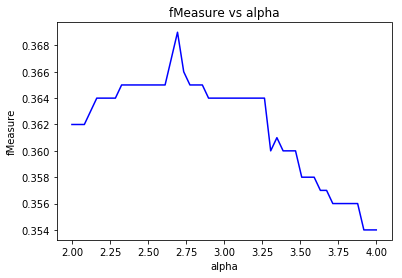

In [206]:
plt.plot(alphas, f1s, c='b')
plt.xlabel("alpha")
plt.ylabel("fMeasure")
plt.title("fMeasure vs alpha")

In [207]:
bestAlpha = alphas[np.argmax(f1s)]
print("Best Alpha " + str(bestAlpha))
print("Max FMeasure for valid " + str(np.max(f1s)))

classifier = sklearn.naive_bayes.BernoulliNB(alpha=bestAlpha)
classifier.fit(yelpTrainBinBag, yelp_train[1])
result = classifier.predict(yelpTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(yelp_test[1], result, average='micro')))

Best Alpha 2.69387755102
Max FMeasure for valid 0.369
FMeasure for test 0.3625


In [208]:
# Naive Bayes classifier - freqBag
classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(yelpTrainFreqBag, yelp_train[1])
result = classifier.predict(yelpTestFreqBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.28649999999999998

In [209]:
# Decision Tree classifier - binBag
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(yelpTrainBinBag, yelp_train[1])
result = tree.predict(yelpTestBinBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.318

In [210]:
# Decision Tree classifier - binBag - hyper-parameter tuning
f1s = []
criterion = ["gini", "entropy"]
splitter = ["best", "random"]

for c in criterion:
    for s in splitter:
        tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
        tree.fit(yelpTrainBinBag, yelp_train[1])
        result = tree.predict(yelpValidBinBag)
        f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0 or arg==1:
    c = "gini"
else:
    c = "entropy"
if arg==0 or arg==2:
    s = "best"
else:
    s = "random"
    
print("For criteria " + str(c) + " and splitter " + str(s))

tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
tree.fit(yelpTrainBinBag, yelp_train[1])
result = tree.predict(yelpTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(yelp_test[1], result, average='micro')))

Highest FMeasure for valid 0.314
For criteria gini and splitter random
FMeasure for test 0.322


In [211]:
# Decision Tree classifier - freqBag
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(yelpTrainFreqBag, yelp_train[1])
result = tree.predict(yelpTestFreqBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.29949999999999999

In [212]:
# Decision Tree classifier - freqBag - hyper-parameter tuning
f1s = []
criterion = ["gini", "entropy"]
splitter = ["best", "random"]

for c in criterion:
    for s in splitter:
        tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
        tree.fit(yelpTrainFreqBag, yelp_train[1])
        result = tree.predict(yelpValidFreqBag)
        f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0 or arg==1:
    c = "gini"
else:
    c = "entropy"
if arg==0 or arg==2:
    s = "best"
else:
    s = "random"
    
print("For criteria " + str(c) + " and splitter " + str(s))

tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
tree.fit(yelpTrainFreqBag, yelp_train[1])
result = tree.predict(yelpTestFreqBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(yelp_test[1], result, average='micro')))

Highest FMeasure for valid 0.307
For criteria gini and splitter random
FMeasure for test 0.2885


In [213]:
# Linear SVM - binBag
svm = sklearn.svm.LinearSVC()
svm.fit(yelpTrainBinBag, yelp_train[1])
result = svm.predict(yelpTestBinBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.37050000000000005

In [214]:
# Linear SVM - binBag - hyper-parameter tuning
f1s = []
penalty = ["l1", "l2"]
loss = ["hinge", "squared_hinge"]

for p in penalty:
    if p=="l1": # combination of "l1" and ("hinge" or "squared_hinge") is not supported
        svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
        svm.fit(yelpTrainBinBag, yelp_train[1])
        result = svm.predict(yelpValidBinBag)
        f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
    else:
        for l in loss:
            svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
            svm.fit(yelpTrainBinBag, yelp_train[1])
            result = svm.predict(yelpValidBinBag)
            f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0:
    p = "l1"
    l = "-"
elif arg==1:
    p = "l2"
    l = "hinge"
elif arg==2:
    p = "l2"
    l = "squared_hinge"
    
print("For penalty " + str(p) + " and loss " + str(l))

if l=="-":
    svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
else:
    svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
svm.fit(yelpTrainBinBag, yelp_train[1])
result = svm.predict(yelpTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(yelp_test[1], result, average='micro')))

Highest FMeasure for valid 0.348
For penalty l1 and loss -
FMeasure for test 0.367


In [215]:
# Linear SVM - freqBag
svm = sklearn.svm.LinearSVC()
svm.fit(yelpTrainFreqBag, yelp_train[1])
result = svm.predict(yelpTestFreqBag)
sklearn.metrics.f1_score(yelp_test[1], result, average='micro')

0.39050000000000007

In [216]:
# Linear SVM - freqBag - hyper-parameter tuning
f1s = []
penalty = ["l1", "l2"]
loss = ["hinge", "squared_hinge"]

for p in penalty:
    if p=="l1": # combination of "l1" and ("hinge" or "squared_hinge") is not supported
        svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
        svm.fit(yelpTrainFreqBag, yelp_train[1])
        result = svm.predict(yelpValidFreqBag)
        f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
    else:
        for l in loss:
            svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
            svm.fit(yelpTrainFreqBag, yelp_train[1])
            result = svm.predict(yelpValidFreqBag)
            f1s.append(sklearn.metrics.f1_score(yelp_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0:
    p = "l1"
    l = "-"
elif arg==1:
    p = "l2"
    l = "hinge"
elif arg==2:
    p = "l2"
    l = "squared_hinge"
    
print("For penalty " + str(p) + " and loss " + str(l))

if l=="-":
    svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
else:
    svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
svm.fit(yelpTrainFreqBag, yelp_train[1])
result = svm.predict(yelpTestFreqBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(yelp_test[1], result, average='micro')))

Highest FMeasure for valid 0.377
For penalty l2 and loss squared_hinge
FMeasure for test 0.3905


# IMDB

In [217]:
# Random classifier
rand = np.random.choice([0,1], len(imdb_test[1]))
sklearn.metrics.f1_score(imdb_test[1], rand, average='micro')

0.50060000000000004

In [218]:
# Majority-class classifier
majority = np.argmax(np.bincount(imdb_train[1]))
majorityArr = np.array([majority]*len(imdb_test[1]))
sklearn.metrics.f1_score(imdb_test[1], majorityArr, average='micro')

0.5

In [219]:
# Naive Bayes classifier - binBag
classifier = sklearn.naive_bayes.BernoulliNB()
classifier.fit(imdbTrainBinBag, imdb_train[1])
result = classifier.predict(imdbTestBinBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.55115999999999998

In [235]:
# Naive Bayes classifier - binBag - hyper-parameter tuning
alphas = np.linspace(3, 5, 50)
f1s = []
for a in alphas:
    classifier = sklearn.naive_bayes.BernoulliNB(alpha=a)
    classifier.fit(imdbTrainBinBag, imdb_train[1])
    result = classifier.predict(imdbValidBinBag)
    f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))

Text(0.5,1,'fMeasure vs alpha')

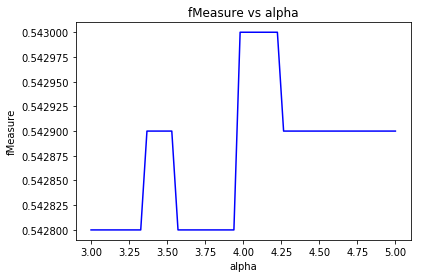

In [236]:
plt.plot(alphas, f1s, c='b')
plt.xlabel("alpha")
plt.ylabel("fMeasure")
plt.title("fMeasure vs alpha")

In [237]:
bestAlpha = alphas[np.argmax(f1s)]
print("Best Alpha " + str(bestAlpha))
print("Max FMeasure for valid " + str(np.max(f1s)))

classifier = sklearn.naive_bayes.BernoulliNB(alpha=bestAlpha)
classifier.fit(imdbTrainBinBag, imdb_train[1])
result = classifier.predict(imdbTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(imdb_test[1], result, average='micro')))

Best Alpha 3.97959183673
Max FMeasure for valid 0.543
FMeasure for test 0.5512


In [223]:
# Naive Bayes classifier - freqBag
classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(imdbTrainFreqBag, imdb_train[1])
result = classifier.predict(imdbTestFreqBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.51632

In [224]:
# Decision Tree classifier - binBag
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(imdbTrainBinBag, imdb_train[1])
result = tree.predict(imdbTestBinBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.53983999999999999

In [225]:
# Decision Tree classifier - binBag - hyper-parameter tuning
f1s = []
criterion = ["gini", "entropy"]
splitter = ["best", "random"]

for c in criterion:
    for s in splitter:
        tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
        tree.fit(imdbTrainBinBag, imdb_train[1])
        result = tree.predict(imdbValidBinBag)
        f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0 or arg==1:
    c = "gini"
else:
    c = "entropy"
if arg==0 or arg==2:
    s = "best"
else:
    s = "random"
    
print("For criteria " + str(c) + " and splitter " + str(s))

tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
tree.fit(imdbTrainBinBag, imdb_train[1])
result = tree.predict(imdbTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(imdb_test[1], result, average='micro')))

Highest FMeasure for valid 0.5381
For criteria gini and splitter random
FMeasure for test 0.53992


In [226]:
# Decision Tree classifier - freqBag
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(imdbTrainFreqBag, imdb_train[1])
result = tree.predict(imdbTestFreqBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.53676000000000001

In [227]:
# Decision Tree classifier - freqBag - hyper-parameter tuning
f1s = []
criterion = ["gini", "entropy"]
splitter = ["best", "random"]

for c in criterion:
    for s in splitter:
        tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
        tree.fit(imdbTrainFreqBag, imdb_train[1])
        result = tree.predict(imdbValidFreqBag)
        f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0 or arg==1:
    c = "gini"
else:
    c = "entropy"
if arg==0 or arg==2:
    s = "best"
else:
    s = "random"
    
print("For criteria " + str(c) + " and splitter " + str(s))

tree = sklearn.tree.DecisionTreeClassifier(criterion=c, splitter=s)
tree.fit(imdbTrainFreqBag, imdb_train[1])
result = tree.predict(imdbTestFreqBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(imdb_test[1], result, average='micro')))

Highest FMeasure for valid 0.5445
For criteria entropy and splitter best
FMeasure for test 0.54016


In [228]:
# Linear SVM - binBag
svm = sklearn.svm.LinearSVC()
svm.fit(imdbTrainBinBag, imdb_train[1])
result = svm.predict(imdbTestBinBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.55664000000000002

In [229]:
# Linear SVM - binBag - hyper-parameter tuning
f1s = []
penalty = ["l1", "l2"]
loss = ["hinge", "squared_hinge"]

for p in penalty:
    if p=="l1": # combination of "l1" and ("hinge" or "squared_hinge") is not supported
        svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
        svm.fit(imdbTrainBinBag, imdb_train[1])
        result = svm.predict(imdbValidBinBag)
        f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
    else:
        for l in loss:
            svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
            svm.fit(imdbTrainBinBag, imdb_train[1])
            result = svm.predict(imdbValidBinBag)
            f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0:
    p = "l1"
    l = "-"
elif arg==1:
    p = "l2"
    l = "hinge"
elif arg==2:
    p = "l2"
    l = "squared_hinge"
    
print("For penalty " + str(p) + " and loss " + str(l))

if l=="-":
    svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
else:
    svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
svm.fit(imdbTrainBinBag, imdb_train[1])
result = svm.predict(imdbTestBinBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(imdb_test[1], result, average='micro')))

Highest FMeasure for valid 0.5508
For penalty l2 and loss hinge
FMeasure for test 0.55628


In [230]:
# Linear SVM - freqBag
svm = sklearn.svm.LinearSVC()
svm.fit(imdbTrainFreqBag, imdb_train[1])
result = svm.predict(imdbTestFreqBag)
sklearn.metrics.f1_score(imdb_test[1], result, average='micro')

0.61228000000000005

In [231]:
# Linear SVM - freqBag - hyper-parameter tuning
f1s = []
penalty = ["l1", "l2"]
loss = ["hinge", "squared_hinge"]

for p in penalty:
    if p=="l1": # combination of "l1" and ("hinge" or "squared_hinge") is not supported
        svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
        svm.fit(imdbTrainFreqBag, imdb_train[1])
        result = svm.predict(imdbValidFreqBag)
        f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
    else:
        for l in loss:
            svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
            svm.fit(imdbTrainFreqBag, imdb_train[1])
            result = svm.predict(imdbValidFreqBag)
            f1s.append(sklearn.metrics.f1_score(imdb_valid[1], result, average='micro'))
        
highestF1 = np.max(f1s)
print("Highest FMeasure for valid "+ str(highestF1))
arg = np.argmax(f1s)
if arg==0:
    p = "l1"
    l = "-"
elif arg==1:
    p = "l2"
    l = "hinge"
elif arg==2:
    p = "l2"
    l = "squared_hinge"
    
print("For penalty " + str(p) + " and loss " + str(l))

if l=="-":
    svm = sklearn.svm.LinearSVC(penalty=p, dual=False)
else:
    svm = sklearn.svm.LinearSVC(penalty=p, loss=l)
svm.fit(imdbTrainFreqBag, imdb_train[1])
result = svm.predict(imdbTestFreqBag)
print("FMeasure for test " + str(sklearn.metrics.f1_score(imdb_test[1], result, average='micro')))

Highest FMeasure for valid 0.6203
For penalty l1 and loss -
FMeasure for test 0.61744
